# Vehicle Detection
---

## Helper Functions

In [276]:
import cv2
import glob
import time
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

def load_image(fname):
    image = cv2.imread(fname)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def plot_images(imgs, titles, figsize=(20, 10), show_axis=True, fname=None, vis=True, cmap='gray'):
    n = len(imgs)
    if n == 1:
        f, ax = plt.subplots(figsize=figsize)
        ax.imshow(imgs[0], cmap=cmap)
        ax.set_title(titles[0], fontsize=20)
        if show_axis is False:
            ax.axis('off')
    else:
        f, axs = plt.subplots(1, n, figsize=figsize)
        for i in range(n):
            axs[i].imshow(imgs[i], cmap=cmap)
            axs[i].set_title(titles[i], fontsize=20)
            if show_axis is False:
                axs[i].axis('off')

    if fname is not None: 
        f.savefig('./output_images/' + fname)

    if vis is True:
        plt.show()

    f.tight_layout()
    plt.close()
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    if color == 'ran':
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    return img_copy

def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(img)
    
    return 'MISSING!'

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for fname in imgs:
        file_features = []
        # get image
        image = load_image(fname)
        
        # apply color conversion
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # spatial features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        # histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
            
        # hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:, :, channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    return features
    
car_examples = ['./data/vehicles/GTI_Far/image0000.png',
                './data/vehicles/GTI_Right/image0000.png',
                './data/vehicles/GTI_Left/image0346.png',
                './data/vehicles/KITTI_extracted/129.png']

notcar_examples = ['./data/non-vehicles/GTI/image1.png',
                    './data/non-vehicles/GTI/image206.png',
                    './data/non-vehicles/GTI/image150.png',
                    './data/non-vehicles/GTI/image3049.png']

## Load and explore data

In [277]:
import glob

cars_path = './data/vehicles/'
not_cars_path = './data/non-vehicles/'

cars = []
notcars = []

for fname in glob.glob(cars_path + '**/*.png', recursive=True):
    cars.append(fname)
    
for fname in glob.glob(not_cars_path + '**/*.png', recursive=True):
    notcars.append(fname)

print('cars:     ', len(cars))
print('not_cars: ', len(notcars))

cars:      8792
not_cars:  8968


### Print image of vehicle and non vehicle

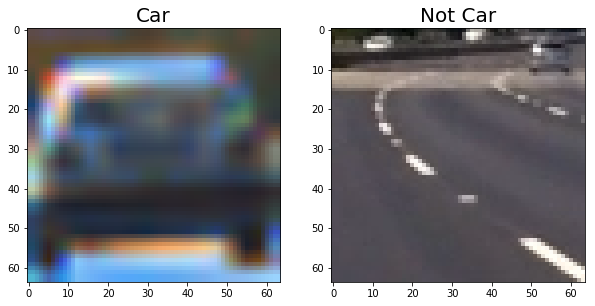

In [280]:
from random import randrange

idx = randrange(min(len(cars),len(notcars)))
car_img = load_image(cars[idx])
notcar_img = load_image(notcars[idx])

plot_images([car_img, notcar_img], 
            ['Car', 'Not Car'], 
            figsize=(10,5), 
            fname='example_images.jpg')

## Train Classifier
---
### Load image features and labels

In [281]:
import numpy as np
from sklearn.preprocessing import StandardScaler

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 9    # Number of histogram bins

car_features = extract_features(cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

notcar_features = extract_features(notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('done')

KeyboardInterrupt: 

### Split data and train classifier

In [11]:
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

pickle.dump(svc, open('./fitted_clf.p', 'wb'))

11.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9947


### Load svc from pickle file

In [ ]:
svc = pickle.load(open("fitted_clf.p", "rb"))
print(svc)

## Sliding Window
---
### Implement sliding window to find cars

In [ ]:
img = load_image('./test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rects = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(stacked)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                bot_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                
                cv2.rectangle(draw_img, top_left, bot_right, (0,0,255), 6) 
                rects.append(((top_left),(bot_right)))
    
    return draw_img, rects
    
flatten = lambda l: [item for sublist in l for item in sublist]

orient = 9
pix_per_cell = 8
cells_per_block = 2
spatial_size = (16, 16)
hist_bins = 9

In [ ]:
rects = []

ystart = 400
ystop = 500
scale = 1.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 416
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)
rects = flatten(rects)

draw_img = draw_boxes(img, rects)
plot_images([draw_img],['Found Rects'], fname='size1_boxes.jpg')

In [ ]:
rects = []

ystart = 400
ystop = 550
scale = 1.5
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 432
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)
rects = flatten(rects)

draw_img = draw_boxes(img, rects)
plot_images([draw_img],['Found Rects'], fname='size2_boxes.jpg')

In [ ]:
rects = []

ystart = 400
ystop = 600
scale = 2.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 432
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)
rects = flatten(rects)

draw_img = draw_boxes(img, rects)
plot_images([draw_img],['Found Rects'], fname='size3_boxes.jpg')

In [ ]:
rects = []

ystart = 400
ystop = 690
scale = 3.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 464
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)
rects = flatten(rects)

draw_img = draw_boxes(img, rects)
plot_images([draw_img],['Found Rects'], fname='size4_boxes.jpg')

In [ ]:
rects = []

ystart = 400
ystop = 500
scale = 1.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 416
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)

ystart = 400
ystop = 550
scale = 1.5
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 432
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)

ystart = 400
ystop = 600
scale = 2.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 432
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)

ystart = 400
ystop = 690
scale = 3.0
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)
rects.append(t_rects)

ystart = 464
draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc,
                              X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, 
                              hist_bins)

rects.append(t_rects)
rects = flatten(rects)

draw_img = draw_boxes(img, rects)
plot_images([draw_img],['Found Rects'], fname='found_rects.jpg')

In [ ]:
def get_heatmap(img, bboxes):
    heatmap = np.zeros_like(img[:,:,0])
    for box in bboxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap

In [ ]:
heatmap = get_heatmap(img, rects)
plot_images([heatmap],['Heatmap'], cmap='hot', fname='heatmap.jpg')

In [ ]:
def heatmap_thresh(heatmap, threshold):
    heatmap_thresh = np.copy(heatmap)
    heatmap_thresh[heatmap_thresh <= threshold] = 0
    return heatmap_thresh

heatmap_t = heatmap_thresh(heatmap, 4)
plot_images([heatmap_t],['Threshold Heatmap'], cmap='hot', fname='heatmap_threshold.jpg')

In [ ]:
from scipy.ndimage.measurements import label

labels = label(heatmap_t)
plot_images([labels[0]], ['Labels'], cmap='gray', fname='labels.jpg')

In [ ]:
def draw_labels(img, labels):
    draw_img = np.copy(img)
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return draw_img, rects

draw_img, rects = draw_labels(img, labels)
plot_images([draw_img], ['Found Cars'])

In [ ]:
def pipeline(img):
    flatten = lambda l: [item for sublist in l for item in sublist]
    rects = []
    
    orient = 9
    pix_per_cell = 8
    cells_per_block = 2
    spatial_size = (16, 16)
    hist_bins = 9
    ystart = 400
    
    ystop = 500
    scale = 1.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 416
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)
    
    ystart = 400
    ystop = 550
    scale = 1.5
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 432
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 400
    ystop = 600
    scale = 2.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 432
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 400
    ystop = 690
    scale = 3.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)
                                  
    ystart = 464
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)
                                  
    rects = flatten(rects)
    heatmap = get_heatmap(img, rects)
    heatmap_t = heatmap_thresh(heatmap, 5)
    labels = label(heatmap_t)
    draw_img, _ = draw_labels(img, labels)
    
    return draw_img

print('pipeline defined')

In [ ]:
fnames = glob.glob('./test_images/test*.jpg')

for i, fname in enumerate(fnames):
    img = load_image(fname)
    plot_images([pipeline(img)], [fname], fname='pipeline_testimg_'+str(i)+'.jpg')

## Run pipeline on video

In [246]:
from moviepy.editor import VideoFileClip

input_path = './test_video.mp4'
output_path = './output_images/test_video_out.mp4'

clip = VideoFileClip(input_path)
vid_clip = clip.fl_image(pipeline)
vid_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_out.mp4
[MoviePy] Writing video ./output_images/test_video_out.mp4


 97%|█████████▋| 38/39 [00:29<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_out.mp4 



### Implement pipeline for video to track car over frames for better bounding box

In [ ]:
class VehicleDetector:
    def __init__(self, smoothing_factor=10):
        self.rects = []
        self.smoothing_factor = smoothing_factor
        
    def add_rects(self, rects):
        self.rects.append(rects)
        self.rects = self.rects[-self.smoothing_factor:]

def pipeline_video(img):
    flatten = lambda l: [item for sublist in l for item in sublist]
    rects = []
    
    orient = 9
    pix_per_cell = 8
    cells_per_block = 2
    spatial_size = (16, 16)
    hist_bins = 9
    ystart = 400
    
    ystop = 500
    scale = 1.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 416
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)
    
    ystart = 400
    ystop = 550
    scale = 1.5
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 432
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 400
    ystop = 600
    scale = 2.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 432
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 400
    ystop = 690
    scale = 3.0
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)

    ystart = 464
    draw_img, t_rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                  pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rects.append(t_rects)
    
    rects = flatten(rects)
    detector.add_rects(rects)
    
    rects = flatten(detector.rects)
    heatmap = get_heatmap(img, rects)
    thresh = 4*(len(detector.rects))
    heatmap_t = heatmap_thresh(heatmap, thresh)
    labels = label(heatmap_t)
    draw_img, _ = draw_labels(img, labels)
    
    return draw_img

#### Run video on new pipeline

In [ ]:
from moviepy.editor import VideoFileClip
detector = VehicleDetector()

input_path = './test_video.mp4'
output_path = './output_images/test_video_out_revised.mp4'

clip = VideoFileClip(input_path)
vid_clip = clip.fl_image(pipeline_video)
vid_clip.write_videofile(output_path, audio=False)

In [256]:
from moviepy.editor import VideoFileClip
detector = VehicleDetector()

input_path = './project_video.mp4'
output_path = './output_images/project_video_out.mp4'

clip = VideoFileClip(input_path)
vid_clip = clip.fl_image(pipeline_video)
vid_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_out.mp4
[MoviePy] Writing video ./output_images/project_video_out.mp4


  5%|▍         | 63/1261 [00:50<16:04,  1.24it/s]

KeyboardInterrupt: 